## "Обнаружение аномалий в финансовых транзакциях с использованием сети автокодировщика"


## 1. Введение

### 1.1 Классификация финансовых аномалий

При детальном изучении реальных журнальных записей, обычно записываемых в крупномасштабных системах AIS или ERP, мы различаем два класса аномальных записей в журнале, а именно «глобальные» и «локальные» аномалии, как показано на рисунке 1 ниже:

<img align="middle" style="max-width: 450px; height: auto" src="https://github.com/GitiHubi/deepAI/blob/master/images/anomalies.png?raw=1">

Рисунок 1: Пример глобальных и локальных аномалий в пространстве двух признаков транзакции «Сумма проводки» (Признак 1 (Ось oY)) и «Позиции проводки» (Признак 2  (Ось oX)).

**Глобальные аномалии** — это финансовые транзакции, которые демонстрируют **необычные или редкие значения отдельных атрибутов**. Эти аномалии обычно связаны с сильно искаженными атрибутами, т.е. редко публикующие сообщения пользователи, редко используемые бухгалтерские книги или необычное время публикации (под публикацией можно понимать запись в БД).

**Локальные аномалии** — это финансовые операции, которые демонстрируют **необычное или редкое сочетание значений атрибутов**, в то время как отдельные значения атрибутов встречаются довольно часто, например, нестандартные бухгалтерские записи.

Этот тип аномалии значительно труднее обнаружить, поскольку мошенники намерены замаскировать свои действия, пытаясь имитировать обычное поведение. В результате такие аномалии обычно представляют высокий риск мошенничества, поскольку они могут соответствовать, например, неправомерно используемым учетным записям пользователей, нерегулярным комбинациям счетов главной книги и ключей публикации, которые не соответствуют обычному шаблону деятельности.

## 2. Настройка среды разработки и её проверка

### 2.1 Импорт библиотек Python

Импортируем библиотеки, необходимые для работы:

In [2]:
# importing utilities
import os
import sys
from datetime import datetime
import io
import urllib

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries: нужны для построения нейронной сети
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

### 2.2 CUDNN и верификация GPU 

Далее проверим, доступен ли CDNN на сервере. Для этого отобразим информацию о доступной версии CUDNN:

In [4]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20220508-16:10:43] The CUDNN backend version: 8200


Кроме того, отобразим информацию о потенциальных графических процессорах, работающих на сервере:

In [5]:
!nvidia-smi # команда терминала, которая показывает доступные видеокарты и их загрузку

Sun May  8 16:11:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# доступна одна видеокарта Tesla K80

### 2.3 Python и PyTorch верификация

Отобразим информацию о версии Python и PyTorch, работающей на сервере:

In [7]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20220508-16:11:18] The Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [8]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20220508-16:11:20] The PyTorch version: 1.11.0+cu113


### 2.4 Инициализация случайного начального числа

Установим детерминированные вычисления и результаты (одинаковые параметры при запуске):

In [9]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

## 3. Набор данных для обнаружения финансового мошенничества

### 3.1 Исходные данные и анализ атрибутов

В этом разделе проведем описательный анализ набора финансовых данных. Кроме того, применим некоторые шаги предварительной обработки для обучения глубокой нейронной сети. Загрузим набор данных и исследуем его структуру и атрибуты:

In [ ]:
# load the dataset 
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)

In [11]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20220508-16:12:01] Transactional dataset of 533009 rows and 10 columns loaded


In [12]:
ori_dataset

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
...,...,...,...,...,...,...,...,...,...,...
533004,446818,C1,C18,C3,C32,A1,B2,2501589.15,0.00,regular
533005,455564,C8,C80,C1,C11,A1,B1,390076.18,12065.45,regular
533006,156896,C1,C10,C1,C19,A1,B1,192147.38,326823.09,regular
533007,455245,C1,C14,C4,C40,A1,B3,870539.68,0.00,regular


Набор данных содержит подмножество из 7 категориальных и 2 числовых атрибутов, доступных в таблицах BKPF (содержащих заголовки  записей журнала) и BSEG (содержащих сегменты записей журнала). 

* BELNR: № документа,
* BUKRS: Код компании (балансовая единица),
* BSCHL: Ключ проводки,
* HKONT: Пользователь, запостивший проводку,
* PRCTR: Центр прибыли,
* WAERS: Код валюты,
* KTOSL: Ключ транзакции для указания налогового счета,
* DMBTR: Сумма в локальной валюте,
* WRBTR: Сумма в валюте документа.



In [13]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


В данных также присутствует метка атрибута (label). Будем использовать это поле во всей работе для оценки качества наших обученных моделей. Поле описывает истинный характер каждой отдельной транзакции, будь то обычная транзакция (обозначается как "regular") или аномалия (обозначается как "global" и "local"). Рассмотрим распределение обычных и аномальных транзакций в наборе данных:

In [14]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

In [15]:
ori_dataset.label.value_counts(normalize=True)

regular    0.999812
global     0.000131
local      0.000056
Name: label, dtype: float64

Статистика показывает, что, как и в реальных сценариях, мы сталкиваемся с крайне «несбалансированным» набором данных. В целом набор данных содержит лишь небольшую часть аномальных транзакций. В то время как 100 аномальных записей охватывают 70 (0,013%) «глобальных» аномалий и 30 (0,005%) «локальных» аномалий.

In [16]:
# удалить информацию о метках  для следующих шагов работы
label = ori_dataset.pop('label')

In [17]:
label

0         regular
1         regular
2         regular
3         regular
4         regular
           ...   
533004    regular
533005    regular
533006    regular
533007    regular
533008    regular
Name: label, Length: 533009, dtype: object

In [18]:
ori_dataset

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00
...,...,...,...,...,...,...,...,...,...
533004,446818,C1,C18,C3,C32,A1,B2,2501589.15,0.00
533005,455564,C8,C80,C1,C11,A1,B1,390076.18,12065.45
533006,156896,C1,C10,C1,C19,A1,B1,192147.38,326823.09
533007,455245,C1,C14,C4,C40,A1,B3,870539.68,0.00


### 3.2 Предварительная обработка категориальных атрибутов транзакции

In [19]:
ori_dataset.dtypes # определяем тип данных атрибутов

BELNR      int64
WAERS     object
BUKRS     object
KTOSL     object
PRCTR     object
BSCHL     object
HKONT     object
DMBTR    float64
WRBTR    float64
dtype: object

Из приведенной выше исходной оценки данных видно, что большинство атрибутов, записанных в ERP системе, соответствуют категориальным (дискретным) значениям атрибутов. 

Нейронные сети, как правило, не предназначены для обучения непосредственно на категориальных данных и требуют, чтобы атрибуты для обучения были числовыми. Одним из простых способов удовлетворить это требование является применение метода **«one-hote-encoding»**. Используя этот метод кодирования, мы получим числовое представление каждого из значений категориального атрибута. Кодирование создает новые двоичные столбцы для каждого значения категориального атрибута, присутствующего в исходных данных.

Использование этого метода будет "one-hot" кодированием 4 категориальных атрибутов в исходном наборе транзакционных данных. Этого можно добиться с помощью функции get_dummies(), доступной в библиотеке данных Pandas:

In [21]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

**В построении модели не будут учитываться атрибумы WAERS (Код валюты), BELNR (№ документа) и BUKRS (Код компании)**, т.к. данные признаки не несут существенной роли при определении мошеннических финансовых операций.

In [22]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,HKONT_V78,HKONT_V92,HKONT_W03,HKONT_W12,HKONT_W62,HKONT_X53,HKONT_Y03,HKONT_Y23,HKONT_Z01,HKONT_Z02
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Предварительная обработка числовых атрибутов

Теперь проверим распределение двух числовых атрибутов, содержащихся в наборе транзакционных данных, а именно:сумма в локальной валюте "DMBTR" и сумма в валюте документа "WRBTR":

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

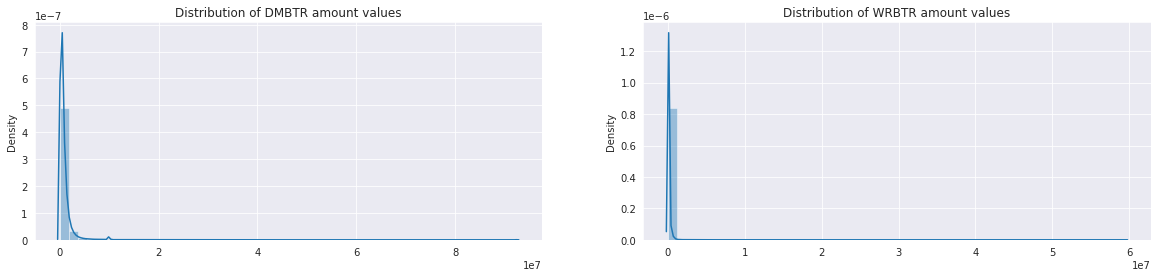

In [23]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute (распределение local amount)
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute (распределение document amount)
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

Можно отметить, что для обоих атрибутов распределения значений количества имеют тяжелые хвосты. Чтобы быстрее приблизиться к потенциальному глобальному минимуму, рекомендуется масштабировать и нормализовать числовые входные значения. Поэтому мы сначала логарифмируем обе переменные, а затем нормализуем их значения в интервале [0, 1] методом min-max. 

Это стандартное действие, когда числовые признаки лежат в разных шкалах.

In [24]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Теперь визуализируем логарифмическое и минимально-максимальное нормализованное распределения обоих атрибутов:

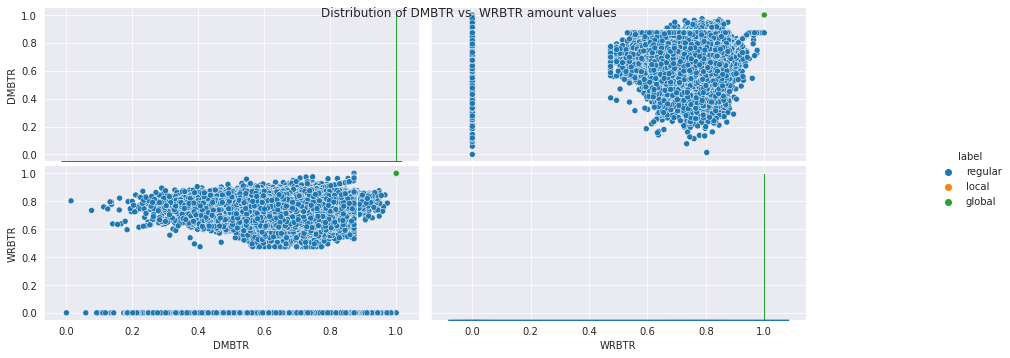

In [25]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

Как ожидалось, числовые значения атрибутов «глобальных» аномалий ("global") выходят за пределы диапазона обычных распределений количества из-за их необычайно высоких значений. Напротив, числовые значения атрибутов «локальных» аномалий ("local") перемешаны с обычными суммами транзакций.

### 3.3 Объединение категориальных и числовых транзакционных атрибутов

Далее, объединим как предварительно обработанные числовые и категориальные атрибуты в единый набор данных, который мы будем использовать для обучения нашей глубокой нейронной сети автоэнкодера (реализовано в  разделе 4):

In [26]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Посмотрим на размерность набора данных после того, как мы применили отдельные шаги предварительной обработки к атрибутам:

In [27]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 384)

После завершения всех шагов предварительной обработки необходимо получить закодированный набор данных, состоящий из 533 009 записей (строк) и 384 закодированных атрибутов (столбцов). Число столбцов будет определять размерность входного и выходного слоев нашей глубокой сети автоэнкодера, которая будет реализована далее.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
ori_subset_transformed.to_csv('/content/drive/MyDrive/Diploma_Polina/precessed_data.csv', index=False) # сохраняем обработанные данные

## 4. Нейронные сети автоэнкодера (AENNs) 

### 4.2 Реализация автоэнкодера

Приступим к реализации автокодировщика, сначала реализовав сеть энкодера с помощью PyTorch. Для энкодера мы стремимся реализовать сеть, состоящую из девяти полносвязных слоев. Кроме того, кодировщик определяется следующим количеством нейронов на слой: «384-256-128-64-32-16-8-4-3». Это означает, что первый слой состоит из 384 нейронов (определяется размерностью наших входных данных), второй слой из 256 нейронов и последующие слои из 128, 64, 32, 16, 8, 4 и 3 нейронов соответственно.

Некоторым элементам приведенного ниже сетевого кода кодировщика следует уделить особое внимание:

> - self.encoder_Lx: определяет линейное преобразование слоя, применяемое к входу: Wx+b. 
> - nn.init.xavier_uniform: устанавливает веса слоев с использованием равномерного распределения  [2]. 
> - self.encoder_Rx: определяет нелинейное преобразование слоя: σ(⋅) - Это функция называется "сигмойда". 
> - self.dropout: случайным образом обнуляет некоторые элементы входного тензора с вероятностью p  [1].

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Diploma_Polina/precessed_data.csv') # загружаем обработанный датасет
df.head()

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,HKONT_W03,HKONT_W12,HKONT_W62,HKONT_X53,HKONT_Y03,HKONT_Y23,HKONT_Z01,HKONT_Z02,DMBTR,WRBTR
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.666635,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.622241,0.838315
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.737149,0.913897
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.796386,0.775564
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.734257,0.645617


In [34]:
count_features = df.shape[1] # количество нейронов на входе и выходе всего автоэнкодера
count_features

384

In [32]:
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)
label = ori_dataset.pop('label') # загружаем лейблы
label

0         regular
1         regular
2         regular
3         regular
4         regular
           ...   
533004    regular
533005    regular
533006    regular
533007    regular
533008    regular
Name: label, Length: 533009, dtype: object

In [35]:
# implementation of the encoder network
class encoder(nn.Module):
    """
    Так определяется подсеть кодировщика на рисунке - это энкодер.
    в методе __init__ определяем блоки сети
    в методе forward опряделяется проход во время обучения и инфреренса (использования потом) сети.
    """
    def __init__(self, in_shape: int, prob_dropout: float = 0.0):
        # in_shape: входная размерность фич, по факту это количество атрибутов полей в датасете
        # prob_dropout: параметр для функции dropout
        super(encoder, self).__init__()

        # specify layer 1 - in 384, out 512
        self.encoder_L1 = nn.Linear(in_features=in_shape, out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [2]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [3]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=prob_dropout, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) # don't apply dropout to the AE bottleneck

        return x

In [36]:
# init training network classes / architectures
encoder_train = encoder(in_shape=count_features) # создание экземпляра кодировщика (энкодера)

# push to cuda if cudnn is available
if torch.cuda.is_available(): # проверка на доступность видеокарты
    device = 'cuda:0' # у нас только одна видеокарта (их нумерация начинается с нуля)
    encoder_train.to(device=device) # т.к. это экземпляр кодировщика, кидаем на видеокарту

После инициализации модели можем визуализировать структуру модели и просмотреть реализованную сетевую архитектуру:

In [37]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20220508-16:32:12] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=384, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_feature

Завершим нейросеть, реализовав соответствующую сеть декодера. Декодер также состоит из девяти полносвязных слоев. Кроме того, сеть декодера предназначена для симметричного отражения архитектуры сети энкодера посредством послойной инверсии «3-4-8-16-32-64-128-256-384» уровней сети энкодера.

In [38]:
# implementation of the decoder network
class decoder(nn.Module):
    # описание аналогично классу encoder
    def __init__(self, out_shape: int, prob_dropout: float = 0.0):
        # out_shape: входная размерность фич, по факту это количество атрибутов полей в датасете
        # prob_dropout: параметр для фукции dropout

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [2]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [3]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 384
        self.decoder_L9 = nn.Linear(in_features=512, out_features=out_shape, bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output
        
        return x

In [39]:
# init training network classes / architectures
decoder_train = decoder(out_shape=count_features) # создание экземпляра декодера

# push to cuda if cudnn is available
if torch.cuda.is_available(): # проверка на доступность видеокарты
    device = 'cuda:0' # у нас только одна видеокарта (их нумерация начинается с нуля)
    decoder_train.to(device=device) # т.к. это экземпляр декодера, кидаем на видеокарту

# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20220508-16:32:33] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=512,

### 4.3 Функция потерь

Теперь, когда мы разработали сеть, ее можно обучить. Перед началом обучения необходимо определить соответствующую функцию потерь. Мы стремимся обучить нашу модель исходя из набора параметров модели кодировщика-декодера **θ**, которые минимизируют несходство данной финансовой транзакции **xi** и ее реконструкции **x^i=gθ(fθ(xi))** настолько точно, насколько это возможно.

Таким образом, цель обучения состоит в том, чтобы изучить набор оптимальных общих параметров модели кодировщика-декодера **θ**, которые оптимизируют **argminθ∥X−gθ(fθ(X))∥** по всем транзакциям или, более конкретно, по записям журнала **X**. Для достижения этой цели оптимизации обычно минимизируют функцию потерь **Lθ** как часть обучения сети. Мы используем потерю, определяемую следующим образом:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

для набора n - записей журнала xi , i=1,...,n и их соответствующих реконструкций x^i и всех атрибутов записей журнала j=1,...,k .

Реализация функции потери уже доступна в PyTorch. Его можно создать «готовым» путем выполнения следующей команды PyTorch:

In [40]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean') # создаем функцию потерь, благодаря которой наша сеть будет обучаться

(Примечание. Включение уменьшения параметра указывает, что потери усредняются по всем наблюдениям для каждой мини-партии).

На основе величины потерь определенного мини-пакета PyTorch автоматически вычисляет градиенты. На основе градиента библиотека также помогает нам в оптимизации и обновлении параметров сети θ.

Мы будем использовать оптимизацию Адама, предложенную в источнике [4], и установим скорость обучения l=0,001. На каждом шаге мини-пакета оптимизатор будет обновлять значения параметров кодера и декодера θ в соответствии со степенью ошибки реконструкции.

In [41]:
# define learning rate and optimization strategy
learning_rate = 1e-3 # шаг обучения - величина, на которую умножаются градиенты (производные функции потерь, чем больше тем быстрее обучимся, но при таком раскладе 
# высока вероятность упасть не в тот локальный минимум. Если меньше, то высока вероятность недобучиться)
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate) # оптимизатор, который изменяет "веса" нейронной сети
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate) # оптимизатор, который изменяет "веса" нейронной сети

Теперь, когда мы успешно внедрили и определили три строительных блока автокодировщика,рассмотрим определения энмодели кодера и декодера, а также потерь. 

## 5. Тренировка модели автоэнкодера

В этом разделе обучим нашу глубокую нейронную сеть автоэнкодера (реализованную в разделе 4) с использованием закодированных транзакционных данных (созданных в разделе 3). В частности, мы подробно рассмотрим отдельные этапы обучения, а также способы отслеживания прогресса обучения.

### 5.1 Подгодотка обучения сети

Мы предварительно обработали набор данных, реализовали автокодировщик и определили ошибку реконструкции. Давайте теперь начнем обучать соответствующую модель для 5 эпох и размера мини-партии из 128 записей в журнале на партию. Это означает, что весь набор данных будет передан в нейросеть 5 раз порциями по 128 записей в журнале, что даст 4165 мини-пакетов (533 009 записей в журнале / 128 записей в мини-пакете) за эпоху.

In [42]:
# specify training parameters
num_epochs = 5 # количество эпох обучения сети
mini_batch_size = 128 # количество экземпляров данных, которые будут входить в один батч. Чем больше, тем лучше, но может выпасть за пределы памяти видеокарты, поэтому такой размер

На этапе обучения будем извлекать отдельные мини-пакеты всей совокупности записей журнала. Для этого мы будем использовать DataLoader PyTorch, который предоставляет итераторы с одним или несколькими процессами для заданного набора данных для загрузки одного мини-пакета за раз. При включении shuffle=True данные будут перетасовываться в каждую эпоху перед их подачей в сеть.

In [43]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(df.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if torch.cuda.is_available():
    dataloader = DataLoader(torch_dataset.to(device=device), batch_size=mini_batch_size, shuffle=True)

### 5.2 Запуск обучения сети

Наконец, приступим к обучению модели. Процедура обучения каждой мини-партии выполняется следующим образом:
>1. сделать прямой проход через часть энкодера-декодера, 
>2. вычислить потери восстановления по функции ошибки (формулу см. выше), 
>3.сделать обратный проход через часть энкодера-декодера, 
>4. и обновить параметры сетей кодировщика fθ(⋅) и декодера gθ(⋅).

Во время обучения нашей модели, будем следить за тем, уменьшаются ли потери по мере продвижения обучения. По этому мы получаем и оцениваем эффективность реконструкции всего набора данных после каждой эпохи обучения. Основываясь на этой оценке, мы можем сделать вывод о ходе обучения и о том, сходятся ли потери (указывая на то, что модель может больше не улучшаться).

Особое внимание следует уделить следующим элементам приведенного ниже кода обучения сети:

> - reconstruction_loss.backward() вычисляет градиенты на основе величины потерь при реконструкции, 
> - encoder_optimizer.step() и decoder_optimizer.step() обновляют параметры сети на основе градиента.


Причиной переключения на ЦП на этапе оценки является размер всего набора данных. Мы стремимся вычислить ошибку реконструкции для всего набора данных, который в большинстве случаев не помещается в память графического процессора.

Кроме того, после каждой эпохи обучения мы хотим сохранить контрольную точку как для фактической модели энкодера, так и для модели декодера. Сохраненные контрольные точки модели содержат моментальный снимок значений параметров обученной модели по завершении эпохи обучения. В целом рекомендуется регулярно сохранять контрольные точки во время обучения. В случае сбоя системы во время обучения можно продолжить с последней контрольной точки, а не начинать с нуля.

> - torch.save(): сохраняет контрольную точку фактических значений параметров модели кодировщика и декодера на диск.

In [44]:
# init collection of epoch losses
epoch_losses = [] # список будет содержать историю функции потерь по эпохам

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset) # преобразовать закодированные транзакционные данные в переменную torch Variable

# train autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    mini_batch_losses = []
    
    # init mini batch counter
    mini_batch_count = 0

    # Это сделано выше    
    # # determine if CUDA is available at compute node
    # if(torch.backends.cudnn.version() != None) and (USE_CUDA == True):
        
    #     # set networks / models in GPU mode
    #     encoder_train.cuda()
    #     decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train() # включаем модуль для тренировки
    decoder_train.train()

    # start timer
    start_time = datetime.now()
        
    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) forward pass ===================================

        # run forward pass (Прогоняем сначала через кодировщик, потом выход кодировщика черех декодер)
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data
        
        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch) # считаем функцию ошибки 
        
        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad() # зануляем градиенты, чтобы накапливать градиенты
        encoder_optimizer.zero_grad() # зануляем градиенты, чтобы накапливать градиенты

        # run backward pass
        reconstruction_loss.backward() # запускаем обратное распространение ошибки для обучения (вычисляем градиенты относительно функции ошибки)
        
        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step() # обновляем веса сети
        encoder_optimizer.step() # обновляем веса сети

        # =================== monitor training progress ==========================
        # смотрим как протекает обучение каждые 1000 итерации внутри одной эпохи
        # print training progress each 1'000 mini-batches
        if mini_batch_count % 1000 == 0:
            
            # print the training mode: either on GPU or CPU
            mode = 'GPU' if torch.cuda.is_available() else 'CPU'
            
            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))

            # reset timer
            start_time = datetime.now()
            
        # collect mini-batch loss (Добавляем значение функции потерь в рамках одной эпохи)
        mini_batch_losses.extend([np.round(reconstruction_loss.item(), 4)])

    # =================== evaluate model performance =============================
                                 
    # collect mean training epoch loss (Усредняем значения функции потерь для одной эпохи)
    epoch_losses.extend([np.mean(mini_batch_losses)])
    
    # print training epoch results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, np.mean(mini_batch_losses)))

    # =================== save model snapshot to disk ============================
    
    # save trained encoder model file to disk
    encoder_model_name = f"/content/drive/MyDrive/Diploma_Polina/model_weights/encoder/ep_{epoch+1}_encoder_model.pth"
    torch.save(encoder_train.state_dict(), encoder_model_name) # сохраняем веса модели

    # save trained decoder model file to disk
    decoder_model_name = f"/content/drive/MyDrive/Diploma_Polina/model_weights/decoder/ep_{epoch+1}_decoder_model.pth"
    torch.save(decoder_train.state_dict(), decoder_model_name)

[LOG 20220508-16:43:36] training status, epoch: [0001/0005], batch: 1000, loss: 0.0145, mode: GPU, time required: 0:00:09.272392
[LOG 20220508-16:43:46] training status, epoch: [0001/0005], batch: 2000, loss: 0.0072, mode: GPU, time required: 0:00:09.088087
[LOG 20220508-16:43:55] training status, epoch: [0001/0005], batch: 3000, loss: 0.007, mode: GPU, time required: 0:00:09.079733
[LOG 20220508-16:44:04] training status, epoch: [0001/0005], batch: 4000, loss: 0.005, mode: GPU, time required: 0:00:09.066713
[LOG 20220508-16:44:05] training status, epoch: [0001/0005], loss: 0.0120919088
[LOG 20220508-16:44:15] training status, epoch: [0002/0005], batch: 1000, loss: 0.0043, mode: GPU, time required: 0:00:09.114986
[LOG 20220508-16:44:24] training status, epoch: [0002/0005], batch: 2000, loss: 0.0039, mode: GPU, time required: 0:00:09.090032
[LOG 20220508-16:44:33] training status, epoch: [0002/0005], batch: 3000, loss: 0.004, mode: GPU, time required: 0:00:09.026162
[LOG 20220508-16:44:

Оценим, действительно ли функция потерь уменьшается по мере обучения модели. Для этого визуализируем величины потерь, полученных за эпоху обучения:

Text(0.5, 1.0, 'AENN training performance')

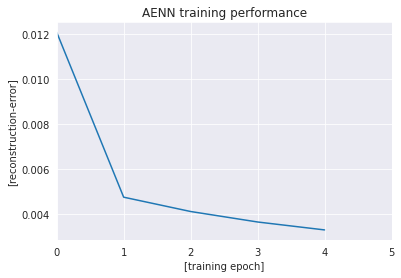

In [45]:
# plot the training progress
plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(epoch_losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance')

После 5 эпох можем наблюдать, что наши потери при реконструкции уже значительно снизились и начинают хорошо сходиться. Это указывает на то, что наша сеть довольно хорошо изучает структуру и атрибуты записей журнала.

Но из графика мы также видим, что модель, вероятно, можно было бы обучить еще на пару эпох, поскольку тенденция ошибки реконструкции все еще уменьшается для последних эпох. В целях экономии времени продолжим работу с использованием предварительно обученной модели, уже обученной на 20 эпох.

## 6. Оценка нейронной сети автоэнкодера

Теперь, когда мы обучили модель автокодировщика, рассмотрим, как можно ее использовать для обнаружения аномалий во всей совокупности записей журнала. Сначала загрузим предварительно обученную модель из 10 эпох и оценим ее возможности реконструкции для всего набора данных.

**Т.к. у авторов автоэнкодера больше мощностей, они обучили модель на 20 эпохах. А как видно из графики функции ошибок по эпохам, она продолжит уменьшение после пяти эпох.**

In [46]:
# restore pretrained model checkpoint (пути до моделей от авторов из репозитория ГИТ)
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/models/ep_20_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/models/ep_20_decoder_model.pth'

# Read stored model from the remote location (Чтение сохраненной модели из удаленного местоположения, то есть из ГИТ)
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# Load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read()) # загружаем тензоры байтовых объектов
decoder_buffer = io.BytesIO(decoder_bytes.read())

count_featers = 384

# init training network classes / architectures
encoder_eval = encoder(count_featers) # инициализируем модель
decoder_eval = decoder(count_featers)

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer)) # загружаем предобученные веса
decoder_eval.load_state_dict(torch.load(decoder_buffer))

<All keys matched successfully>

### 6.1 Оценка предварительно обученной модели

После получения  воспользуемся моделью для реконструкции всего набора данных:

In [47]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset) # конвертируем данные в тип torch Variable

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval() # переключаем модель в режим тестирования, то есть отключаем функции, которые были при обучении, например, dropout
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

Сравнение общей потери реконструкции предварительно обученной модели, обученной в течение 10 эпох, с той, которую мы изначально обучали в течение 5 эпох, показывает, что предварительно обученная модель приводит к значительно меньшей ошибке реконструкции. Таким образом, мы можем сделать вывод, что предварительно обученная модель превосходит нашу исходную модель в захвате неотъемлемых характеристик записей журнала.

Далее, будем использовать предобученную модель от авторов.

### 6.2 Оценка отдельных транзакций

Когда мы убедились, что предварительно обученная модель имеет достойное качество, оценим отдельные записи в журнале набора данных. Для этого мы собираем ошибки реконструкции каждой отдельной записи в журнале:

In [48]:
# init binary cross entropy errors (Инициализируем нулями ошибку BCELoss)
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]): # итерируемся по реконструированной ра

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

[LOG 20220508-16:57:18] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20220508-16:57:27] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20220508-16:57:39] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20220508-16:57:52] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20220508-16:58:03] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20220508-16:58:14] collected individual reconstruction loss of: 500000/533009 transactions


После того, как собрали отдельные ошибки реконструкции визуализируем их:

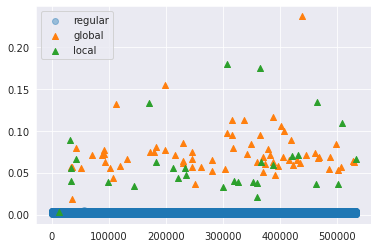

In [49]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

Визуализация показывает, что предварительно обученная модель способна реконструировать большинство обычных записей журнала, но не может этого сделать для аномальных. В результате ошибку реконструкции модели можно использовать, чтобы отличить как «глобальные» аномалии (оранжевый), так и «локальные» аномалии (зеленый) от обычных записей журнала (синий).



Для дальнейшего изучения нашего наблюдения и подтверждения первоначального предположения изучим записи в журнале, демонстрирующие «высокую» ошибку реконструкции >= 0,1. Мы предполагаем, что эти записи журнала соответствуют «глобальным» аномалиям исходного набора данных:

In [50]:
# append labels to original dataset
ori_dataset['label'] = label

# inspect transactions exhibiting a reconstruction error >= 0.1 (проверка транзакции с ошибкой реконструкции >= 0.1)
ori_dataset[reconstruction_loss_transaction >= 0.1]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
113179,532969,H01,E65,O50,F20,M83,V78,9.244552e+07,5.958503e+07,global
170320,533001,C1,C11,C1,C30,A1,B1,9.106460e+05,5.445281e+04,local
199041,532968,K99,T17,C84,L74,T28,N47,9.244551e+07,5.958501e+07,global
306995,532990,C1,C11,C1,C39,A1,B1,9.106485e+05,5.442850e+04,local
315589,532920,P79,N56,N39,P47,H17,S52,9.244551e+07,5.958503e+07,global
336799,532940,N15,G51,G09,S21,E99,W62,9.244553e+07,5.958505e+07,global
364695,533009,C1,C11,C1,C32,A1,B1,9.106585e+05,5.443274e+04,local
387184,532970,L47,W77,C76,K02,M65,H02,9.244552e+07,5.958504e+07,global
401639,532965,R09,H05,D89,B70,Z68,K21,9.244551e+07,5.958503e+07,global
438816,532931,T87,V13,R30,C03,F26,G64,9.244553e+07,5.958504e+07,global


Теперь рассмотрим записи журнала, демонстрирующие «среднюю» ошибку реконструкции >= 0,05 и <0,1. Мы предполагаем, что эти записи журнала в основном соответствуют «локальным» аномалиям исходного набора данных:

In [51]:
# inspect transactions exhibiting a reconstruction error < 0.1 and >= 0.05 
# проверять транзакции с ошибкой реконструкции < 0,1 и >= 0,05 ()
ori_dataset[(reconstruction_loss_transaction >= 0.05) & (reconstruction_loss_transaction < 0.1)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
32317,532989,C1,C11,C1,C53,A1,B1,9.106530e+05,5.443921e+04,local
33365,532942,W59,C13,P83,I73,I05,Q99,9.244552e+07,5.958504e+07,global
34059,533003,C1,C11,C1,C64,A1,B1,9.106316e+05,5.444328e+04,local
35944,532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global
41925,532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global
...,...,...,...,...,...,...,...,...,...,...
502255,532954,J38,C30,G28,T38,C62,L03,9.244551e+07,5.958503e+07,global
506926,532948,U72,D58,E35,Y05,D53,F61,9.244551e+07,5.958505e+07,global
528449,532959,C89,S43,E40,Y34,L29,N28,9.244553e+07,5.958504e+07,global
528759,532910,P36,V48,Z17,J68,Q50,J62,9.244554e+07,5.958504e+07,global


Как мы видим, ошибка реконструкции  >= 0,1 показывает как глобальные, так и локальные аномалии, так же как и ошибка реконструкции < 0,1 и >= 0,05, но обычные транзакции отсуствуют.

## Список использованных источников

[1] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[2] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[3] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[4] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.
